# Load packages

In [1]:
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
import json
import numpy as np

In [2]:
import sys

sys.path.append("../../resource/DexiNed")
sys.path.append("../../src")

from model import DexiNed
from dataset import BIPEDv2, transforms

# Prepare

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epoch = 50
batch_size = 8
learning_rate = 1e-4
biped_dataset = BIPEDv2(
    "/home/yangk/intership_2025_COSYS/resource/DexiNed/BIPEDv2/BIPED/edges/imgs/train/rgbr/real/",
    "/home/yangk/intership_2025_COSYS/resource/DexiNed/BIPEDv2/BIPED/edges/edge_maps/train/rgbr/real/"
)
# test set
test_dataset = BIPEDv2(
    "/home/yangk/intership_2025_COSYS/resource/DexiNed/BIPEDv2/BIPED/edges/imgs/test/rgbr/",
    "/home/yangk/intership_2025_COSYS/resource/DexiNed/BIPEDv2/BIPED/edges/edge_maps/test/rgbr/"
)

model = DexiNed()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loader = DataLoader(biped_dataset, batch_size=4)
val_loader = DataLoader(test_dataset, batch_size=4)
logging = {
    'metadata': {},
    'train_loss': [],
    'val_loss': []
}


print(device)

cuda


# Train

In [17]:
import os
# set checkpoint file name
file_stem = "cpt_visibility_02"
description = "with validation loss, and replace the sum of loss of each layers to the average"

if not os.path.isfile(f"./checkpoints/{file_stem}.json"): # First train
    logging['metadata'] = {"description": description, "num_epoch":epoch, "batch_size":batch_size, "criterion": "MSE", "learning_rate": learning_rate}
    model = model.to(device)
    for e in range(epoch):
        # train step
        model.train()
        epoche_loss = []
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = sum([criterion(output.squeeze(), y) for output in outputs]) / len(outputs)
            loss.backward()
            optimizer.step()
            print("*", end="", flush=True)
            epoche_loss.append(loss.detach().item())
        logging['train_loss'].append(np.mean(epoche_loss))
        print(f"\nIn epoch {e}, the average  training  loss is {logging['train_loss'][-1]}")
        # validation step
        model.eval()
        val_epoch_loss = []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = sum([criterion(output.squeeze(), y) for output in outputs]) / len(outputs)
                val_epoch_loss.append(loss.detach().item())
        logging['val_loss'].append(np.mean(val_epoch_loss))
        print(f"\nIn epoch {e}, the average validation loss is {logging['val_loss'][-1]}")
    model = model.to('cpu')
    # save files
    # file_stem = "cpt_visibility_01"
    torch.save(model.state_dict(), f"./checkpoints/{file_stem}.pth")
    print(f"Succeed saving mdoel parameters in ./checkpoints/{file_stem}.pth.")
    with open(f"./checkpoints/{file_stem}.json", "w") as f:
        json.dump(logging, f)
    print(f"Succeed saving log in ./checkpoints/{file_stem}.json")
else: # already trained
    # load model
    model.load_state_dict(torch.load(f"./checkpoints/{file_stem}.pth", weights_only=True))
    # load log
    with open(f"./checkpoints/{file_stem}.json", 'r') as f:
        logging = json.load(f)
    # print the loss
    for e, (train_loss, val_loss) in enumerate(zip(logging['train_loss'], logging['val_loss'])):
        print("-".join(["-"]*30))
        print(f"\nIn epoch {e}, the average  training  loss is {train_loss}")
        print(f"\nIn epoch {e}, the average validation loss is {train_loss}")

-----------------------------------------------------------

In epoch 0, the average  training  loss is 649.8005575561524

In epoch 0, the average validation loss is 649.8005575561524
-----------------------------------------------------------

In epoch 1, the average  training  loss is 642.0268420410156

In epoch 1, the average validation loss is 642.0268420410156
-----------------------------------------------------------

In epoch 2, the average  training  loss is 638.1998568725586

In epoch 2, the average validation loss is 638.1998568725586
-----------------------------------------------------------

In epoch 3, the average  training  loss is 634.8619250488281

In epoch 3, the average validation loss is 634.8619250488281
-----------------------------------------------------------

In epoch 4, the average  training  loss is 631.6076263427734

In epoch 4, the average validation loss is 631.6076263427734
-----------------------------------------------------------

In epoch 5, the ave

# Result

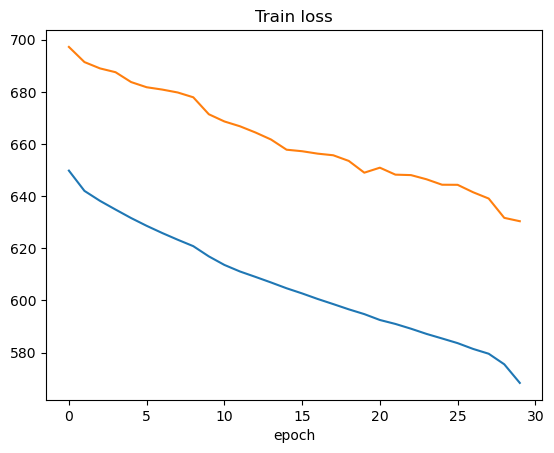

In [12]:
import matplotlib.pyplot as plt

plt.plot(logging['train_loss'])
plt.plot(logging['val_loss'])
plt.title("Train loss")
plt.xlabel("epoch")
plt.show()

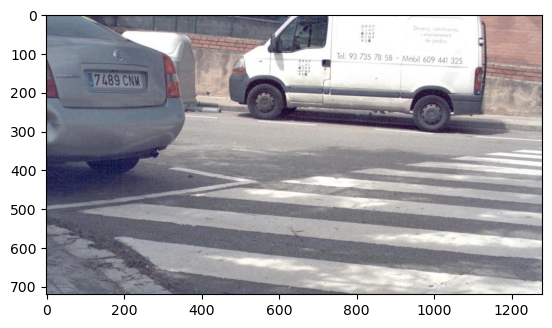

In [18]:
# take one example
x, y = biped_dataset[6]

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
denormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],  
    std=[1/s for s in std]
)


plt.imshow(denormalize(x).permute(1,2,0))
plt.show()

In [19]:
model.eval()
with torch.no_grad():
    model.to(device)
    yhat = model(x.unsqueeze(0).to(device))[-1].squeeze()
    yhat = yhat.to('cpu')
    model.to('cpu')

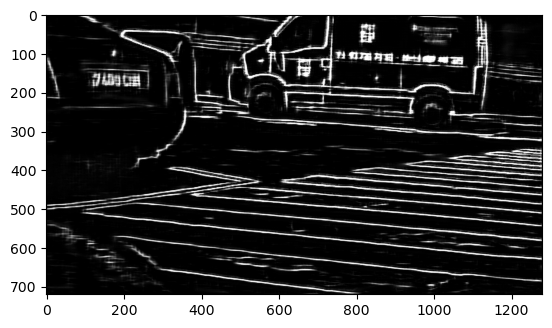

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def normalisation(img, percentile=95):
    res = img / np.percentile(img, percentile)
    res = np.where(res<0, 0, res)
    res = np.where(res>1, 1, res) 
    return res

plt.imshow(normalisation(yhat), cmap="gray")
plt.show()

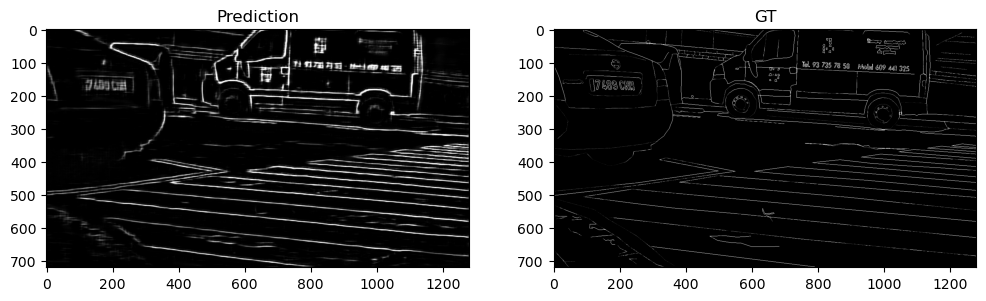

In [21]:
# display result
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
# fig.suptitle(img_index)
ax1.imshow(normalisation(yhat, 98), cmap="gray")
ax1.set_title("Prediction")
ax2.imshow(normalisation(y, 98), cmap="gray")
ax2.set_title("GT")
plt.show()